In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors
from tensorflow.keras import layers
from tensorflow.keras.losses import categorical_crossentropy
from keras.layers import Dense, Dropout, LSTM

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/augusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/augusto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [2]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'])

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])

print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  Estou contente com a compra entrega rápida o ú...
1                    4  Por apenas R$1994.20,eu consegui comprar esse ...
2                    4  SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3                    4  MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4                    5  A entrega foi no prazo, as americanas estão de...
...                ...                                                ...
132368               5  Vale muito, estou usando no controle do Xbox e...
132369               5  Prático e barato, super indico o produto para ...
132370               4  Chegou antes do prazo previsto e corresponde a...
132371               1  Material fraco, poderia ser melhor. Ficou deve...
132372               1  Comprei esse produto, quando chegou estava com...

[132373 rows x 2 columns]>


In [3]:
# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [4]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [5]:
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  contente compra entrega rapida unico problema ...
1                    4        apenas consegui comprar lindo copo acrilico
2                    4  supera agilidade praticidade outras panelas el...
3                    4          filho amou parece verdade tantos detalhes
4                    5  entrega prazo americanas estao parabens smart ...
...                ...                                                ...
132368               5  vale usando controle xbox durou semana carga p...
132369               5  pratico barato super indico produto corre dia ...
132370               4    chegou antes prazo previsto corresponde anuncio
132371               1  material fraco poderia ser melhor ficou devend...
132372               1  comprei produto chegou avaria devolvi ja vai f...

[132373 rows x 2 columns]>


In [6]:
b2wCorpus.overall_rating .value_counts().sort_index()

1    27369
2     8389
3    16315
4    32345
5    47955
Name: overall_rating, dtype: int64

In [7]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    1  nao deveria sequer avaliar produto afinal so r...
1                    1  nao gostei vendedor pois pro lema chave ate mo...
2                    5  produto excelente leve pratico potente montage...
3                    5        produto chegou conforme esperado satisfeita
4                    5  amei produto realmente valeu pena comprar voce...
...                ...                                                ...
132368               5  usando produto achei excelente enquanto recome...
132369               1  gostaria saber aconteceu produto nao chegou ainda
132370               1            dias receber produto comprei dois ainda
132371               2  aparelhjo ee todo plastico pendulo nao real re...
132372               3        comprei figurinhas veio apenas decepcionado

[132373 rows x 2 columns]>


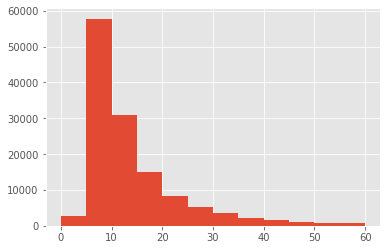

130344


In [8]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=60 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.show()
print(len(Words))

In [9]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '0'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [10]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [11]:
b2wCorpus.shape

(132373, 3)

In [12]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 10].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > 50].index)

In [13]:
b2wCorpus['overall_rating'] = b2wCorpus.overall_rating.apply(lambda x: x - 1)

In [14]:
b2wCorpus.shape

(68406, 3)

In [15]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [16]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,0,"[7804, 6376, 8059, 290, 2142, 9193, 2405, 1887...",21
1,4,"[902, 2104, 2694, 63936, 12574, 5117, 54465, 1...",36
2,4,"[16476, 902, 871, 6432, 1135, 1815, 36387, 780...",26
3,0,"[902, 2648, 7279, 79, 173, 128, 4581, 7431, 11...",26
4,4,"[902, 161274, 532, 0, 3330, 428, 131, 566, 855...",12


In [17]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [18]:
#b2wCorpus.review_text.str.rjust(width=50, fillchar='0')
#np.reshape(y_train,(-1))

b2wCorpus.review_text = keras.preprocessing.sequence.pad_sequences(b2wCorpus.apply(lambda row: np.reshape(row.review_text,(-1)), axis=1), maxlen=50, padding='post').tolist()

In [19]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,0,"[7804, 6376, 8059, 290, 2142, 9193, 2405, 1887...",21
1,4,"[902, 2104, 2694, 63936, 12574, 5117, 54465, 1...",36
2,4,"[16476, 902, 871, 6432, 1135, 1815, 36387, 780...",26
3,0,"[902, 2648, 7279, 79, 173, 128, 4581, 7431, 11...",26
4,4,"[902, 161274, 532, 0, 3330, 428, 131, 566, 855...",12


In [20]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [21]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [22]:
b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

,overall_rating,review_text,ord
38246,2,"[9735, 902, 7256, 566, 276, 442, 1624, 1446, 6...",50
12499,0,"[902, 7804, 428, 62, 2294, 948, 1912, 1150, 13...",50
36974,1,"[902, 532, 3230, 2114, 7433, 33293, 902, 428, ...",50
30790,0,"[45028, 9878, 1664, 86, 21469, 36387, 7804, 37...",50
36481,2,"[0, 5437, 122, 101071, 428, 131, 1322, 785, 11...",50


In [23]:
b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
6209                4  [7804, 3448, 221, 3006, 406, 26649, 6624, 245,...   50
35719               1  [3620, 18874, 3974, 70, 21849, 312, 164, 25236...   50
31449               0  [7804, 3143, 4853, 532, 902, 164, 28604, 59590...   50
22459               4  [22744, 1954, 1135, 160164, 5437, 7804, 1470, ...   50
30608               2  [902, 713, 226, 37681, 20452, 40087, 7804, 242...   50
...               ...                                                ...  ...
67111               4  [3395, 5625, 44653, 3078, 984, 122, 5185, 4349...   10
63349               2  [94, 943, 3844, 93, 316, 1362, 1914, 394, 91, ...   10
5441                3  [101071, 902, 428, 131, 578, 1761, 1083, 600, ...   10
50702               4  [31512, 2789, 61637, 1239, 70, 131, 566, 902, ...   10
58383               4  [17999, 23933, 21531, 25244, 23933, 9233, 913,...   10

[6840 rows x 3 columns]>

In [24]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
54235               0  [2420, 7804, 2832, 2989, 62, 117, 141, 234, 17...   50
9408                0  [131, 3384, 600, 2335, 3385, 451, 2190, 3919, ...   50
16005               0  [145, 1517, 43308, 1664, 162, 82, 330, 321, 19...   50
64352               4  [6376, 902, 0, 191205, 131710, 55606, 0, 0, 0,...   50
53932               4  [7256, 141, 2104, 532, 3512, 620, 16450, 1705,...   50
...               ...                                                ...  ...
27710               0  [3711, 1686, 862, 8766, 32617, 12783, 0, 0, 12...   10
39143               4  [2104, 902, 22522, 3006, 2694, 54465, 0, 10723...   10
238                 4  [226, 6645, 86, 86, 63936, 9496, 635, 45525, 1...   10
13923               3  [902, 0, 7431, 3816, 70, 18874, 265, 428, 131,...   10
34592               0  [0, 428, 0, 10547, 7804, 2832, 902, 117, 2288,...   10

[17103 rows x 3 columns]>

In [25]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [28]:
# Treino, Validação e teste
RANDOM_SEED = 42
x_train =  [ emb for emb in b2wCorpusTrain.review_text]
y_train =   b2wCorpusTrain.overall_rating
x_val = [ emb for emb in b2wCorpusValidate.review_text ]
y_val = b2wCorpusValidate.overall_rating
x_train = np.asarray(x_train)
x_val =np.asarray(x_val)

np.random.seed(RANDOM_SEED)
model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')
emb = model.get_keras_embedding()

In [29]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
SEQUENCE_MAXLEN = 50
model = keras.Sequential()
model.add(layers.Input(shape=(SEQUENCE_MAXLEN, )))
model.add(emb)
model.add(layers.LSTM(128, activation='relu',return_sequences=True))
#model.add(Dropout(0.2))
model.add(keras.layers.LSTM(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(keras.layers.Dense(32, activation='relu'))
#model.add(Dropout(0.2))
model.add(keras.layers.Dense(5, activation='softmax'))
#opt = tf.keras.optimizers.SGD(learning_rate=.1, momentum=.5)
#opt = tf.keras.optimizers.Adamax(learning_rate=0.01, beta_1=.9, beta_2=.9, epsilon=1e-07, name="Adamax")
#model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc', 'mae'])
opt="adam"
model.compile(optimizer=opt,loss=sparse_categorical_crossentropy, metrics=["accuracy"])
history = model.fit(
    x= x_train, y=y_train, batch_size=128, epochs=50, validation_data=(x_val, y_val)
)

Epoch 1/50
348/348 [==============================] - 27s 79ms/step - loss: 1.4881 - accuracy: 0.3700 - val_loss: 188.4880 - val_accuracy: 0.5132
Epoch 2/50
348/348 [==============================] - 27s 78ms/step - loss: 3.7283 - accuracy: 0.4996 - val_loss: 1.1615 - val_accuracy: 0.5355
Epoch 3/50
348/348 [==============================] - 27s 78ms/step - loss: 1.1418 - accuracy: 0.5339 - val_loss: 1.1372 - val_accuracy: 0.5363
Epoch 4/50
348/348 [==============================] - 27s 78ms/step - loss: 1.0993 - accuracy: 0.5418 - val_loss: 1.1093 - val_accuracy: 0.5433
Epoch 5/50
348/348 [==============================] - 25s 73ms/step - loss: 1.0740 - accuracy: 0.5489 - val_loss: 16.8076 - val_accuracy: 0.5494
Epoch 6/50
348/348 [==============================] - 25s 73ms/step - loss: 1.5194 - accuracy: 0.4931 - val_loss: 1.1911 - val_accuracy: 0.5276
Epoch 7/50
348/348 [==============================] - 26s 74ms/step - loss: 1.1614 - accuracy: 0.5275 - val_loss: 1.1365 - val_accura

KeyboardInterrupt: 

In [ ]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

In [ ]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();